# Filtragem de imagens e contornos com OpenCV

**Atenção**: Rode este notebook com `jupyter notebook` e não `jupyter lab`. A parte interativa requer que seja específico

Tópicos:
- [Equalização de histograma](#equalizacao)
- [Limiarização](#limiarizacao)
- [Deteção de cores com inRange](#inrange)
- [Componentes conexos e contornos](#compconexos)
- [Operações morfológicas](#morfologia)

Bibliografia: 

[Cap.5 - Computer Vision. Shapiro](https://courses.cs.washington.edu/courses/cse576/book/ch5.pdf)

[Cap.3 - Digital Image Processing. Gonzales / Woods](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/Digital_Image_Processing_2ndEd.pdf)

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
import sys
import math
print ("OpenCV Version : %s " % cv2.__version__)

from ipywidgets import widgets, interact, interactive, FloatSlider, IntSlider

import auxiliar as aux

if (sys.version_info > (3, 0)): 
    # Modo Python 3
    import importlib
    importlib.reload(aux) # Para garantir que o Jupyter sempre relê seu trabalho
else:
    # Modo Python 2
    reload(aux)



OpenCV Version : 4.5.1 


<div id="equalizacao"></div>

# Equalização de histograma

Vamos rever equalização e definir limiarização

In [2]:
rintin = cv2.imread("RinTinTin.jpg", cv2.IMREAD_GRAYSCALE)

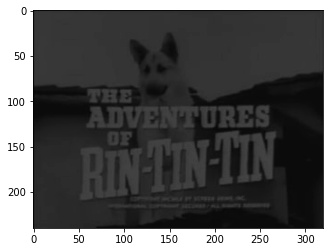

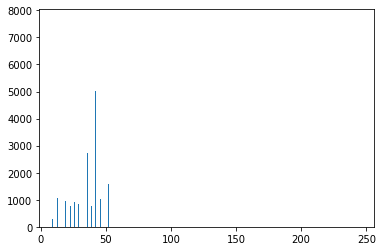

In [3]:
plt.imshow(rintin, cmap="Greys_r", vmin=0, vmax=255)
plt.show()
plt.hist(rintin.flatten(), bins=256)
plt.xlim([-1,256])
plt.show()


Pode-se, de forma prática, usar a função `cv2.equalizeHist` [para equalizar um histograma](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)

In [4]:
rintin_eq = cv2.equalizeHist(rintin)

Verifiquemos o resultado

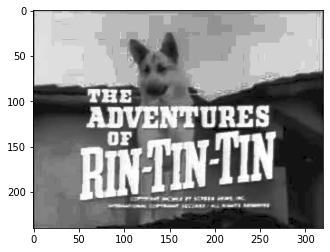

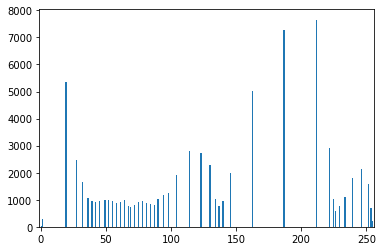

In [5]:
plt.imshow(rintin_eq, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.hist(rintin_eq.flatten(), bins=256)
plt.xlim([-1,256])
plt.show()

<div id="limiarizacao"></div>

## Limiarização

Para a limiarização, converte-se uma imagem em tons de cinza para uma imagem binária. A função `cv2.threshold` [é capaz de fazê-lo](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

In [6]:
ret,limiarizada = cv2.threshold(rintin_eq,thresh=120,maxval=255,type=cv2.THRESH_BINARY)


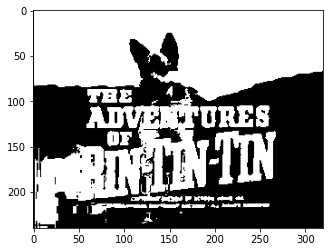

In [7]:
plt.imshow(limiarizada, cmap="gray")
plt.show()

<div id="filtragem"></div>

<div id="inrange"></div>

# Deteção de cores com inRange

O espaço de cores HSV é nosso amigo

![](https://upload.wikimedia.org/wikipedia/commons/8/8f/HSV_cylinder.jpg)

Imagem "linkada" do Wikipedia 

In [8]:
img_color = cv2.imread("hall_box_battery1.jpg")
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)


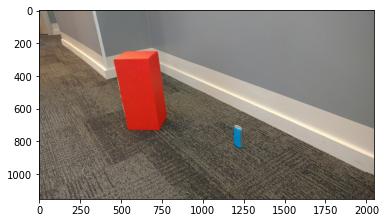

In [9]:
plt.imshow(img_rgb)
plt.show()

In [10]:
colorpicker = widgets.ColorPicker(
    concise=False,
    description='Escolha uma cor',
    value='#ff0e00',
    disabled=False
)

In [11]:
colorpicker

ColorPicker(value='#ff0e00', description='Escolha uma cor')

In [12]:
hsv1, hsv2 = aux.ranges(colorpicker.value)

In [13]:
hsv1

array([ 0, 50, 50], dtype=uint8)

In [14]:
hsv2

array([ 10, 255, 255], dtype=uint8)

In [15]:
mask = cv2.inRange(img_hsv, hsv1, hsv2)    

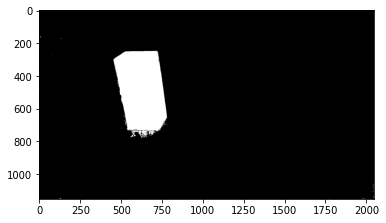

In [16]:
plt.imshow(mask, cmap="gray")
plt.show()

In [17]:
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

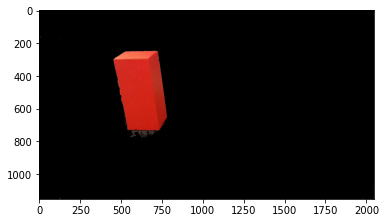

In [18]:
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
plt.imshow(selecao)
plt.show()

<div id="compconexos"></div>

## Componentes conexos e contornos

E se tivéssemos mais de um objeto vermelho na imagem? Como faríamos para identificá-los?

Fonte das imagens: [http://time.com/4299724/coca-cola-diet-coke-redesign/](http://time.com/4299724/coca-cola-diet-coke-redesign/)

In [40]:
coke = cv2.imread("coke-cans.jpg")
coke_rgb= cv2.cvtColor(coke, cv2.COLOR_BGR2RGB)
coke_hsv= cv2.cvtColor(coke, cv2.COLOR_BGR2HSV)

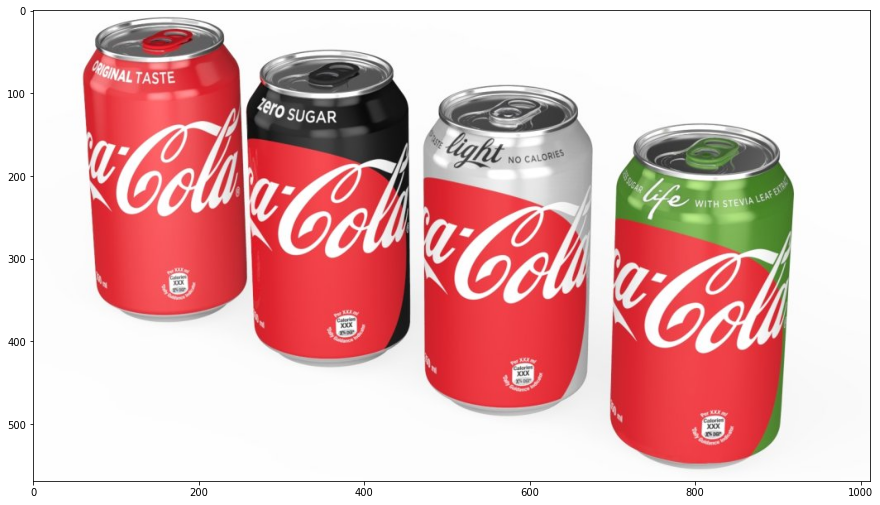

In [41]:
plt.figure(figsize=(15,10))
plt.imshow(coke_rgb)
plt.show()

Para detectar vermelho em HSV, não se esquecer de seelcionar a faixa inferior e a superior do canal H

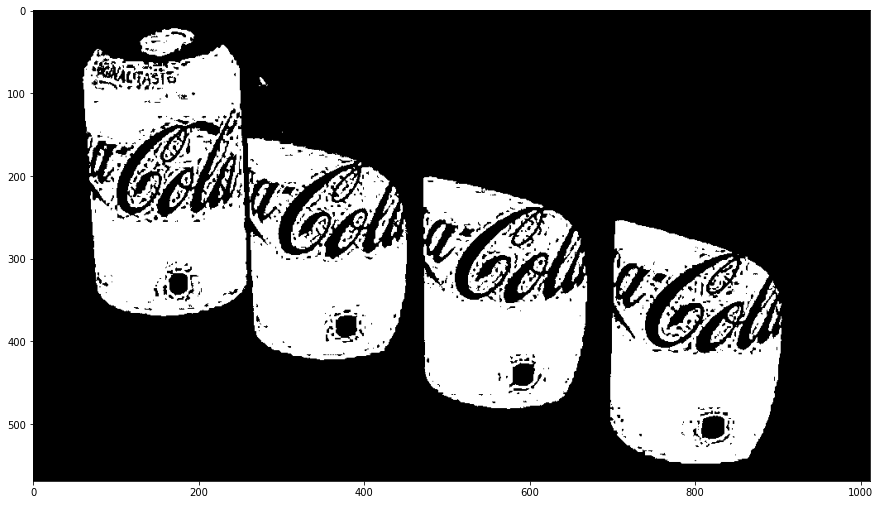

In [42]:
cor_menor1 = np.array([172, 50, 50])
cor_maior1 = np.array([180, 255, 255])
mask_coke1 = cv2.inRange(coke_hsv, cor_menor1, cor_maior1)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke1, cmap='gray')
plt.show()


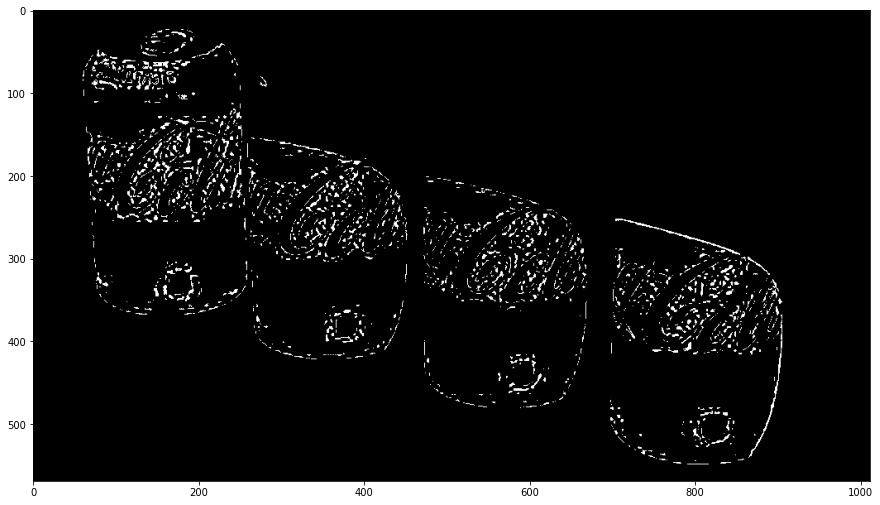

In [43]:
cor_menor2 = np.array([0, 50, 50])
cor_maior2 = np.array([8, 255, 255])
mask_coke2 = cv2.inRange(coke_hsv, cor_menor2, cor_maior2)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke2, cmap='gray')
plt.show()

In [44]:
# Juntando as máscaras
mask_coke = cv2.bitwise_or(mask_coke1,mask_coke2)

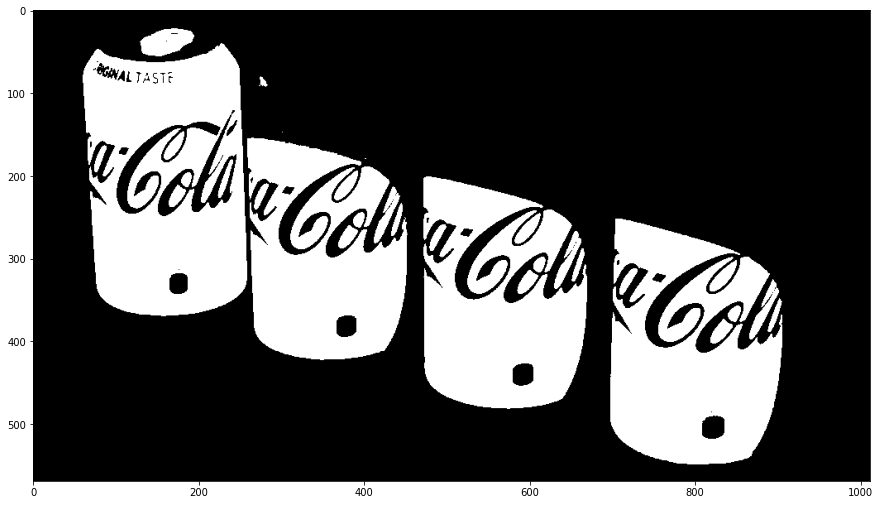

In [45]:
plt.figure(figsize=(15,10))
plt.imshow(mask_coke, cmap="gray", vmin=0, vmax=255)
plt.show()

## Componentes conexos

Após a segmentação da imagem por mascaramento, podemos observar que os pixels de interesse podem formar um ou mais grupos conectados entre si, ou seja, conjuntos de pixels que se comunicam através de algum caminho que passa apenas por pixels de interesse (brancos)

![](retangulos.bmp) -> ![](retangulos_mask.bmp) -> ![](retangulos_ccomp.bmp)

No OpenCV, é possível encontrar componente conexos em imagens tons de cinza através da função `cv2.findContours()`. Ela considera pixels de valor maior do que 0 como pixels de interesse. 

Usamos a função da forma:

```
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
```
onde:
- `mask` é a imagem com a máscara binária
- `cv2.RETR_CCOMP` indica que queremos organizar os contornos em componentes conexos e buracos dentro deles
- `cv2.CHAIN_APPROX_NONE` indica que queremos armazenar todos os pontos do contorno
- `contours` é uma lista de contornos, contendo os pontos a ele pertencententes
- `hierarchy` é uma lista indicando a organização dos contornos em termos dos componentes e de seus buracos


Os componentes conexos são representados através de seus contornos internos, ou seja, dos pixels de cada componente conexo que são vizinhos a pixels de fundo. Para desenhar os contornos em uma imagem, usamos a função `cv2.drawContours()`, que usamos da forma:

```
cv2.drawContours(imagem, contours, indice, cor)
```
- `imagem` é a imagem colorida ou tons de cinza a receber o contorno
- `contours` é a lista de contornos obtida com `cv2.findContours()`
- `indice` é o índice do contorno dentro da lista a ser desenhado; se indice < 0 desenha todos os contornos
- `cor` é a cor do pixel a ser usada para desenhar o contorno   



In [46]:
# Para OpenCV cv2 versão 3 use a linha abaixo:
#img_out, contornos, arvore = cv2.findContours(segmentado_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
contornos, arvore = cv2.findContours(mask_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
len(contornos)

111

In [47]:
contornos_img = coke_rgb.copy()
cv2.drawContours(contornos_img, contornos, -1, [0, 0, 255], 3);

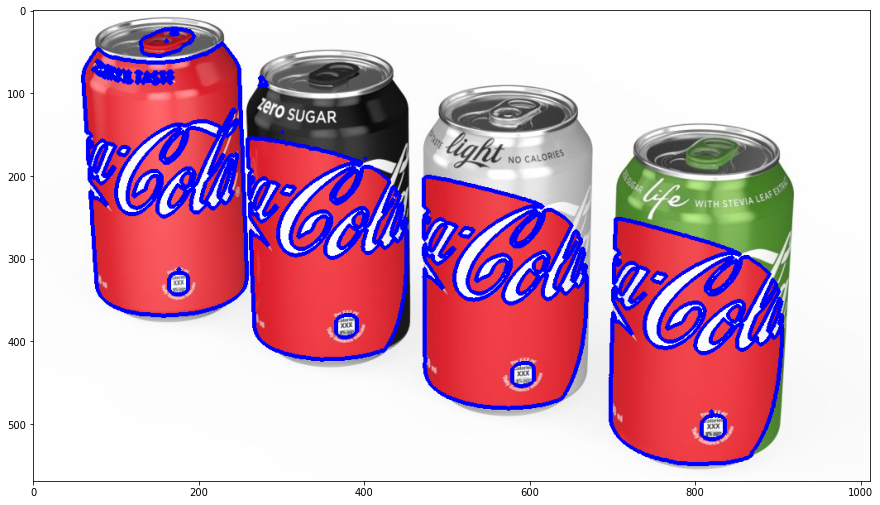

In [48]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

### Medidas dos contornos

A partir dos contornos, podemos tirar uma série de medidas como:
- **Área:** número de pixels petencentes ao contorno, calculada com `cv2.contourArea(contour)`
- **Centro de massa:** linha e coluna do centro de masssa do contorno

**Exemplo:** calcula o componente conexo de maior área e desenha seu contorno e o ponto do centro de massa 

#### Maior contorno

In [49]:
maior = None
maior_area = 0
for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
        maior_area = area
        maior = c

In [50]:
cv2.drawContours(contornos_img, [maior], -1, [0, 255, 255], 5);


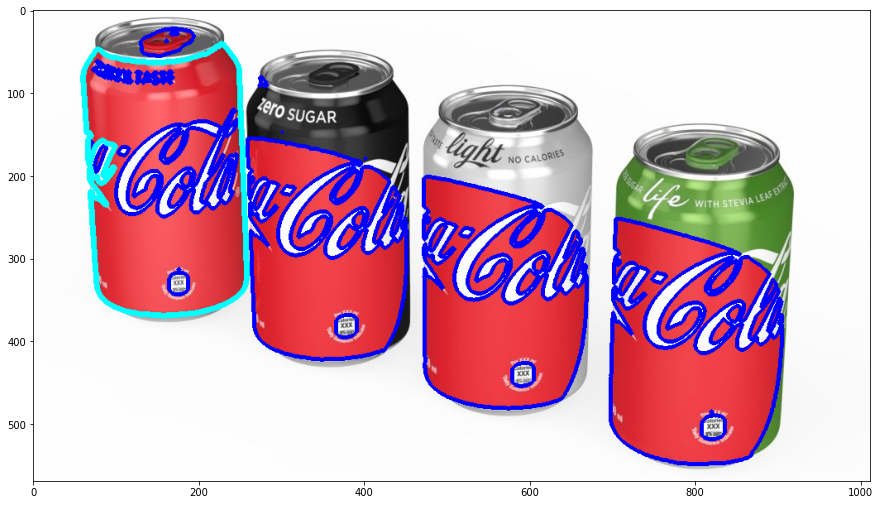

In [52]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

#### Centro de massa do contorno.

**Jeito 1** - mais preciso

In [54]:
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,5)
    cv2.line(img,(x,y - size),(x, y + size),color,5)

In [55]:
""" Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
M = cv2.moments(maior)
# Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

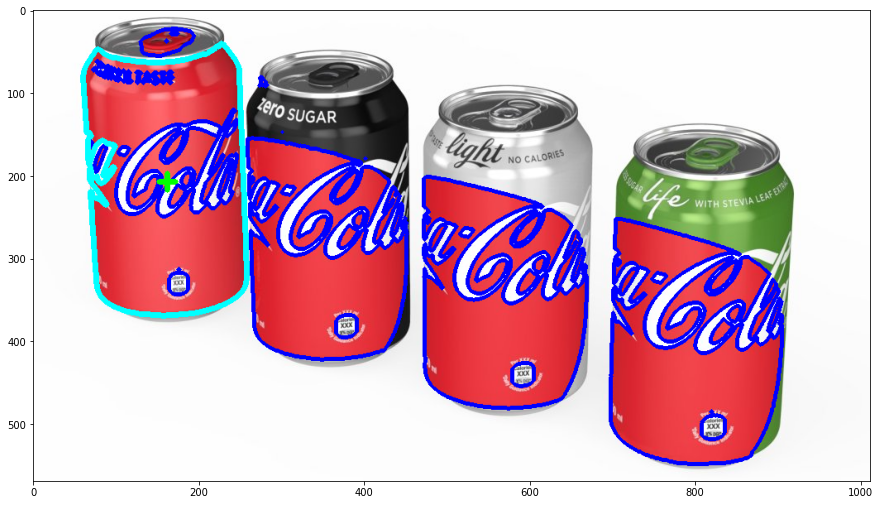

In [56]:
crosshair(contornos_img, (cX,cY), 10, (0,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

**Jeito 2** - aproximado

**ATENÇÃO:** essa técnica de calcular o centro de massa diretamente do contorno dá resultados melhores quando usado com contornos convexos e `cv2.CHAIN_APPROX_NONE`. Em outros casos, é melhor fazer como no jeito 1.

In [34]:
cX = int(maior[:,:,0].mean())
cY = int(maior[:,:,1].mean())

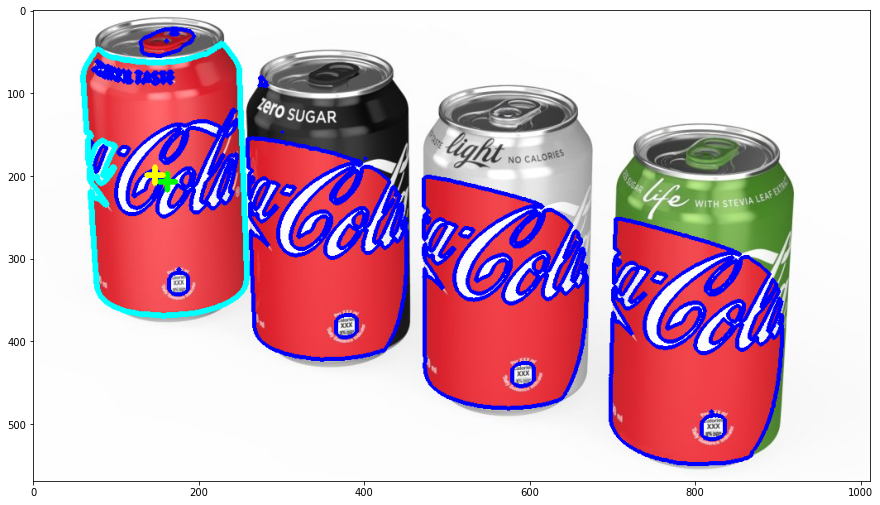

In [35]:
crosshair(contornos_img, (cX,cY), 10, (255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

<div id="hough"></div>